In [ ]:
# Setup Project Paths
import os
import sys

# Set project paths
PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) if '__file__' in globals() else os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(PROJECT_ROOT, 'datasetfiles')
MODEL_DIR = os.path.join(PROJECT_ROOT, 'model_files')

print(f"📁 Project Root: {PROJECT_ROOT}")
print(f"📊 Data Directory: {DATA_DIR}")
print(f"🤖 Model Directory: {MODEL_DIR}")

# Verify directories
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Data directory not found: {DATA_DIR}")
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"✅ Created model directory: {MODEL_DIR}")

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import glob
import json
from datetime import datetime

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
import joblib

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 1. Load Data

In [3]:
# Load Training Data
print("\n📊 Loading training data...")

# Look for dataset files with new naming convention
train_file = os.path.join(DATA_DIR, "smart_fisher_train.csv")
full_file = os.path.join(DATA_DIR, "smart_fisher_full_dataset.csv")

# Try multiple file patterns
if os.path.exists(train_file):
    df_train = pd.read_csv(train_file)
    print(f"   ✅ Loaded: smart_fisher_train.csv - {len(df_train):,} rows")
elif os.path.exists(full_file):
    df = pd.read_csv(full_file)
    # Split into train/test
    df_train = df.sample(frac=0.8, random_state=42)
    df_test_temp = df.drop(df_train.index)
    # Save for later
    df_test_temp.to_csv(os.path.join(DATA_DIR, "smart_fisher_test.csv"), index=False)
    print(f"   ✅ Loaded and split full dataset: {len(df_train):,} train, {len(df_test_temp):,} test rows")
    df_train = df_train.reset_index(drop=True)
else:
    # Fallback to old file pattern
    train_files = glob.glob(os.path.join(DATA_DIR, "*_train*.csv"))
    if not train_files:
        raise FileNotFoundError(f"No training files found in {DATA_DIR}")
    
    train_dfs = []
    for file in sorted(train_files):
        df = pd.read_csv(file)
        train_dfs.append(df)
        print(f"   ✅ {os.path.basename(file)}: {len(df):,} rows")
    
    df_train = pd.concat(train_dfs, ignore_index=True)

print(f"\n✅ Total training data: {len(df_train):,} rows")
print(f"   Columns: {df_train.shape[1]}")
print(f"   Sample columns: {df_train.columns.tolist()[:10]}")


📊 Loading training data...
   ✅ Loaded: smart_fisher_train.csv - 16,000 rows

✅ Total training data: 16,000 rows
   Columns: 45
   Sample columns: ['trip_id', 'trip_year', 'trip_month', 'trip_date', 'season', 'boat_type', 'boat_name', 'engine_hp', 'fuel_type', 'crew_size']


In [4]:
# Load Test Data
print("\n📊 Loading test data...")

test_file = os.path.join(DATA_DIR, "smart_fisher_test.csv")

if os.path.exists(test_file):
    df_test = pd.read_csv(test_file)
    print(f"   ✅ Loaded: smart_fisher_test.csv - {len(df_test):,} rows")
else:
    # Look for test files with pattern
    test_files = glob.glob(os.path.join(DATA_DIR, "*_test*.csv"))
    
    if not test_files:
        print("⚠️ No test files found - will split from training data later")
        df_test = None
    else:
        test_dfs = []
        for file in sorted(test_files):
            df = pd.read_csv(file)
            test_dfs.append(df)
            print(f"   ✅ {os.path.basename(file)}: {len(df):,} rows")
        
        df_test = pd.concat(test_dfs, ignore_index=True)
        print(f"\n✅ Total test data: {len(df_test):,} rows")


📊 Loading test data...
   ✅ Loaded: smart_fisher_test.csv - 4,000 rows


## 2. Data Preprocessing with Pipeline

In [5]:
# Data Overview
print("\n" + "="*70)
print("DATA QUALITY CHECK")
print("="*70)

print(f"\n📊 Training Shape: {df_train.shape}")
print(f"   Missing values: {df_train.isnull().sum().sum()}")
print(f"   Duplicates: {df_train.duplicated().sum()}")

if df_test is not None:
    print(f"\n📊 Test Shape: {df_test.shape}")
    print(f"   Missing values: {df_test.isnull().sum().sum()}")

print(f"\n🚤 Boat Type Distribution:")
print(df_train['boat_type'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))

# Check for new cost column names (lowercase with underscores)
cost_cols = []
if 'fuel_cost_lkr' in df_train.columns:
    cost_cols = ['fuel_cost_lkr', 'ice_cost_lkr', 'water_cost_lkr', 'total_base_cost_lkr']
elif 'fuel_cost_LKR' in df_train.columns:
    cost_cols = ['fuel_cost_LKR', 'ice_cost_LKR', 'total_cost_LKR']
else:
    # Find cost columns
    cost_cols = [col for col in df_train.columns if 'cost' in col.lower()]

if cost_cols:
    print(f"\n💰 Cost Statistics (Training Data):")
    available_cost_cols = [col for col in cost_cols if col in df_train.columns]
    print(df_train[available_cost_cols].describe().round(0))


DATA QUALITY CHECK

📊 Training Shape: (16000, 45)
   Missing values: 0
   Duplicates: 0

📊 Test Shape: (4000, 45)
   Missing values: 0

🚤 Boat Type Distribution:
boat_type
OBFR    40.0%
MDBT    25.1%
TKBO    15.0%
IMUL    14.9%
NMTR     5.0%
Name: proportion, dtype: object

💰 Cost Statistics (Training Data):
       fuel_cost_lkr  ice_cost_lkr  water_cost_lkr  total_base_cost_lkr
count        16000.0       16000.0         16000.0              16000.0
mean        457008.0       10614.0            80.0             467702.0
std        1098160.0       25638.0           131.0            1121298.0
min              0.0         216.0             0.0                259.0
25%          23385.0         257.0             0.0              23852.0
50%          53065.0         536.0            53.0              54000.0
75%         126259.0        2398.0            89.0             128155.0
max        8952342.0      131561.0           857.0            9042932.0


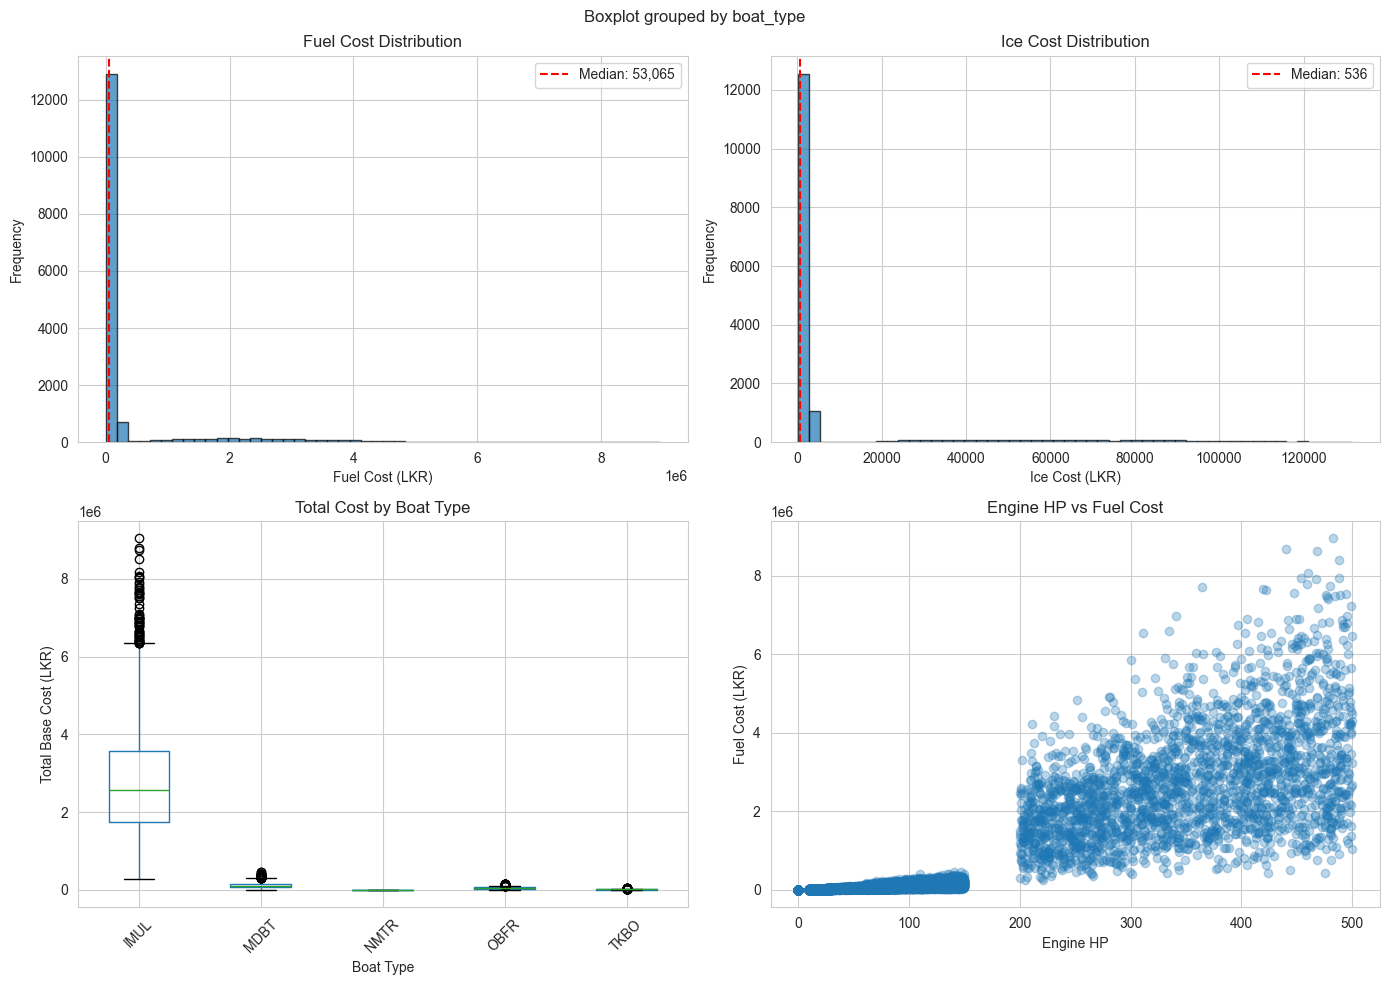

✅ Cost distributions visualized


In [6]:
# Visualize Cost Distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Detect column naming convention
fuel_col = 'fuel_cost_lkr' if 'fuel_cost_lkr' in df_train.columns else 'fuel_cost_LKR'
ice_col = 'ice_cost_lkr' if 'ice_cost_lkr' in df_train.columns else 'ice_cost_LKR'
total_col = 'total_base_cost_lkr' if 'total_base_cost_lkr' in df_train.columns else 'total_cost_LKR'
engine_col = 'engine_hp' if 'engine_hp' in df_train.columns else 'engine_HP'

# Fuel cost distribution
if fuel_col in df_train.columns:
    axes[0, 0].hist(df_train[fuel_col], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Fuel Cost (LKR)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Fuel Cost Distribution')
    axes[0, 0].axvline(df_train[fuel_col].median(), color='red', linestyle='--', 
                       label=f"Median: {df_train[fuel_col].median():,.0f}")
    axes[0, 0].legend()

# Ice cost distribution
if ice_col in df_train.columns:
    axes[0, 1].hist(df_train[ice_col], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Ice Cost (LKR)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Ice Cost Distribution')
    axes[0, 1].axvline(df_train[ice_col].median(), color='red', linestyle='--', 
                       label=f"Median: {df_train[ice_col].median():,.0f}")
    axes[0, 1].legend()

# Total cost by boat type
if total_col in df_train.columns:
    df_train.boxplot(column=total_col, by='boat_type', ax=axes[1, 0])
    axes[1, 0].set_xlabel('Boat Type')
    axes[1, 0].set_ylabel('Total Base Cost (LKR)')
    axes[1, 0].set_title('Total Cost by Boat Type')
    plt.sca(axes[1, 0])
    plt.xticks(rotation=45)

# HP vs Fuel Cost
if engine_col in df_train.columns and fuel_col in df_train.columns:
    axes[1, 1].scatter(df_train[engine_col], df_train[fuel_col], alpha=0.3)
    axes[1, 1].set_xlabel('Engine HP')
    axes[1, 1].set_ylabel('Fuel Cost (LKR)')
    axes[1, 1].set_title('Engine HP vs Fuel Cost')

plt.tight_layout()
plt.show()

print("✅ Cost distributions visualized")

## 3. Feature Engineering

In [7]:
# Define Features and Targets
print("\n" + "="*70)
print("FEATURE ENGINEERING")
print("="*70)

# TARGETS: Multi-output prediction (Fuel, Ice, Water costs)
# Detect column naming convention
if 'fuel_cost_lkr' in df_train.columns:
    target_columns = ['fuel_cost_lkr', 'ice_cost_lkr', 'water_cost_lkr', 'total_base_cost_lkr']
else:
    # Old naming - create water cost as 0 for backward compatibility
    if 'water_cost_LKR' not in df_train.columns:
        df_train['water_cost_LKR'] = 0
        if df_test is not None:
            df_test['water_cost_LKR'] = 0
    
    df_train['base_cost_LKR'] = df_train['fuel_cost_LKR'] + df_train['ice_cost_LKR'] + df_train['water_cost_LKR']
    if df_test is not None:
        df_test['base_cost_LKR'] = df_test['fuel_cost_LKR'] + df_test['ice_cost_LKR'] + df_test['water_cost_LKR']
    
    target_columns = ['fuel_cost_LKR', 'ice_cost_LKR', 'water_cost_LKR', 'base_cost_LKR']

print(f"\n🎯 Target Variables (Multi-output):")
for i, target in enumerate(target_columns, 1):
    if target in df_train.columns:
        print(f"   {i}. {target} - Mean: LKR {df_train[target].mean():,.0f}")

# FEATURES: What we know at planning time
# Exclude cost columns, IDs, dates, and derived revenue/profit columns
exclude_cols = [
    'trip_id', 'year', 'trip_date', 'fuel_date_used', 'trip_start_date', 'trip_end_date',
    # All cost columns (old and new naming)
    'fuel_cost_LKR', 'ice_cost_LKR', 'crew_cost_LKR', 'water_cost_LKR',
    'gear_loss_cost_LKR', 'total_cost_LKR', 'base_cost_LKR',
    'fuel_cost_lkr', 'ice_cost_lkr', 'water_cost_lkr', 'total_base_cost_lkr',
    # Revenue and profit columns
    'gross_revenue_LKR', 'tax_amount_LKR', 'net_revenue_LKR',
    'gross_profit_LKR', 'net_profit_margin', 'external_costs_LKR',
    'fuel_cost_share', 'crew_cost_share', 'profitability',
    'total_revenue_lkr', 'net_profit_lkr', 'profit_margin',
    # Quantity columns if we're predicting costs directly
    'fuel_liters', 'ice_kg', 'water_liters'
]

# Also exclude catch and revenue columns
catch_revenue_cols = [col for col in df_train.columns 
                      if 'catch_' in col.lower() or 'revenue_' in col.lower()]
exclude_cols.extend(catch_revenue_cols)

# Select input features
input_features = [col for col in df_train.columns 
                  if col not in exclude_cols and col not in target_columns]

print(f"\n📋 Selected {len(input_features)} input features:")
for i, feat in enumerate(input_features[:15], 1):  # Show first 15
    print(f"   {i:2d}. {feat}")
if len(input_features) > 15:
    print(f"   ... and {len(input_features) - 15} more")

print(f"\n✅ Multi-output prediction setup complete")
print(f"   Features: {len(input_features)}")
print(f"   Targets: {len(target_columns)}")


FEATURE ENGINEERING

🎯 Target Variables (Multi-output):
   1. fuel_cost_lkr - Mean: LKR 457,008
   2. ice_cost_lkr - Mean: LKR 10,614
   3. water_cost_lkr - Mean: LKR 80
   4. total_base_cost_lkr - Mean: LKR 467,702

📋 Selected 35 input features:
    1. trip_year
    2. trip_month
    3. season
    4. boat_type
    5. boat_name
    6. engine_hp
    7. fuel_type
    8. crew_size
    9. ice_capacity_kg
   10. water_capacity_L
   11. avg_speed_knots
   12. avg_speed_kmh
   13. trip_days
   14. trip_duration_category
   15. port_name
   ... and 20 more

✅ Multi-output prediction setup complete
   Features: 35
   Targets: 4


In [8]:
# Prepare Features and Targets
print("\n📊 Preparing modeling dataset...")

# Create features and targets
available_features = [f for f in input_features if f in df_train.columns]
available_targets = [t for t in target_columns if t in df_train.columns]

X = df_train[available_features].copy()
y = df_train[available_targets].copy()

print(f"\n✅ Dataset prepared:")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")
print(f"   Features used: {len(available_features)}")
print(f"   Targets: {len(available_targets)}")

# Check for missing values
missing_x = X.isnull().sum().sum()
missing_y = y.isnull().sum().sum()

if missing_x > 0:
    print(f"\n⚠️ Found {missing_x} missing values in features")
    # Fill missing values
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    X[categorical_cols] = X[categorical_cols].fillna('unknown')
    print(f"   ✅ Missing values handled")

if missing_y > 0:
    print(f"\n⚠️ Found {missing_y} missing values in targets - removing rows")
    valid_idx = y.notnull().all(axis=1)
    X = X[valid_idx]
    y = y[valid_idx]
    print(f"   ✅ Cleaned dataset: {len(X)} rows")


📊 Preparing modeling dataset...

✅ Dataset prepared:
   X shape: (16000, 35)
   y shape: (16000, 4)
   Features used: 35
   Targets: 4


## 4. Data Preprocessing

In [9]:
# Identify Column Types
print("\n" + "="*70)
print("DATA PREPROCESSING PIPELINE")
print("="*70)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n🔤 Categorical features ({len(categorical_cols)}):")
for cat in categorical_cols:
    n_unique = X[cat].nunique()
    print(f"   - {cat}: {n_unique} unique values")

print(f"\n🔢 Numerical features: {len(numerical_cols)}")

# Create preprocessing pipelines
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Numerical pipeline: Scale features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical pipeline: One-hot encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

print(f"\n✅ Preprocessing pipeline created:")
print(f"   - Numerical: StandardScaler")
print(f"   - Categorical: OneHotEncoder")
print(f"   - Total input features: {len(available_features)}")
print(f"   - After encoding: Will be determined after fit")


DATA PREPROCESSING PIPELINE

🔤 Categorical features (7):
   - season: 2 unique values
   - boat_type: 5 unique values
   - boat_name: 5 unique values
   - fuel_type: 4 unique values
   - trip_duration_category: 2 unique values
   - port_name: 8 unique values
   - region: 5 unique values

🔢 Numerical features: 28

✅ Preprocessing pipeline created:
   - Numerical: StandardScaler
   - Categorical: OneHotEncoder
   - Total input features: 35
   - After encoding: Will be determined after fit


In [10]:
# Train-Test Split
print("\n📊 Creating train/test split...")

if df_test is not None and all(t in df_test.columns for t in available_targets):
    # Use separate test set
    X_train = X
    y_train = y
    
    X_test = df_test[available_features].copy()
    y_test = df_test[available_targets].copy()
    
    # Handle missing values in test set
    numeric_cols_test = X_test.select_dtypes(include=[np.number]).columns
    X_test[numeric_cols_test] = X_test[numeric_cols_test].fillna(X_test[numeric_cols_test].median())
    categorical_cols_test = X_test.select_dtypes(include=['object', 'category']).columns
    X_test[categorical_cols_test] = X_test[categorical_cols_test].fillna('unknown')
    
    print(f"   ✅ Using separate test set")
else:
    # Split from training data (stratified by boat_type if available)
    stratify_col = X['boat_type'] if 'boat_type' in X.columns else None
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=stratify_col
    )
    print(f"   ✅ Created 80/20 split from training data")

print(f"\n✅ Data split complete:")
print(f"   Training: {len(X_train):,} samples")
print(f"   Test: {len(X_test):,} samples")
print(f"   Feature dimensions: {X_train.shape[1]}")
print(f"   Target dimensions: {y_train.shape[1]}")


📊 Creating train/test split...
   ✅ Using separate test set

✅ Data split complete:
   Training: 16,000 samples
   Test: 4,000 samples
   Feature dimensions: 35
   Target dimensions: 4


## 3. Multi-Output Model Training

**Multi-Output Regression Strategy:**
- Predict all cost components simultaneously (Fuel + Ice + Water + Total)
- Use `MultiOutputRegressor` wrapper for models that don't support multi-output natively
- Evaluate each output separately and overall performance
- Better handles correlations between cost components

In [11]:
# Initialize Multi-Output Models
print("\n" + "="*70)
print("MULTI-OUTPUT MODEL TRAINING")
print("="*70)

# Define models with MultiOutputRegressor wrapper
models = {
    'Random Forest': MultiOutputRegressor(RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )),
    
    'XGBoost': MultiOutputRegressor(XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )),
    
    'Gradient Boosting': MultiOutputRegressor(GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )),
    
    'Ridge Regression': MultiOutputRegressor(Ridge(
        alpha=1.0,
        random_state=42
    )),
    
    'Lasso Regression': MultiOutputRegressor(Lasso(
        alpha=1.0,
        random_state=42,
        max_iter=2000
    ))
}

print(f"\n🤖 Training {len(models)} multi-output models...")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")
print(f"   Input features: {X_train.shape[1]}")
print(f"   Output targets: {y_train.shape[1]}")


MULTI-OUTPUT MODEL TRAINING

🤖 Training 5 multi-output models...
   Training samples: 16,000
   Test samples: 4,000
   Input features: 35
   Output targets: 4


In [13]:
# Train Models with Pipeline
results = {}
trained_pipelines = {}

for name, model in models.items():
    print(f"\n{'='*70}")
    print(f"Training: {name}")
    print(f"{'='*70}")
    
    # Create full pipeline (preprocessing + model)
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Fit the pipeline
    print("   Fitting pipeline...")
    pipeline.fit(X_train, y_train)
    trained_pipelines[name] = pipeline
    
    # Make predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate metrics for each target
    target_metrics = {}
    for i, target in enumerate(available_targets):
        # Training metrics
        train_r2 = r2_score(y_train.iloc[:, i], y_train_pred[:, i])
        train_rmse = np.sqrt(mean_squared_error(y_train.iloc[:, i], y_train_pred[:, i]))
        train_mae = mean_absolute_error(y_train.iloc[:, i], y_train_pred[:, i])
        
        # Test metrics
        test_r2 = r2_score(y_test.iloc[:, i], y_test_pred[:, i])
        test_rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_test_pred[:, i]))
        test_mae = mean_absolute_error(y_test.iloc[:, i], y_test_pred[:, i])
        
        # MAPE (avoiding division by zero)
        test_mape = np.mean(np.abs((y_test.iloc[:, i] - y_test_pred[:, i]) / (y_test.iloc[:, i] + 1e-6))) * 100
        
        target_metrics[target] = {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'r2_gap': train_r2 - test_r2,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'test_mape': test_mape
        }
    
    # Calculate average metrics
    avg_test_r2 = np.mean([m['test_r2'] for m in target_metrics.values()])
    avg_test_rmse = np.mean([m['test_rmse'] for m in target_metrics.values()])
    avg_test_mae = np.mean([m['test_mae'] for m in target_metrics.values()])
    avg_test_mape = np.mean([m['test_mape'] for m in target_metrics.values()])
    avg_r2_gap = np.mean([m['r2_gap'] for m in target_metrics.values()])
    
    results[name] = {
        'target_metrics': target_metrics,
        'avg_test_r2': avg_test_r2,
        'avg_test_rmse': avg_test_rmse,
        'avg_test_mae': avg_test_mae,
        'avg_test_mape': avg_test_mape,
        'avg_r2_gap': avg_r2_gap
    }
    
    print(f"\n   📊 Average Performance:")
    print(f"      Test R²: {avg_test_r2:.4f} ({avg_test_r2*100:.2f}%)")
    print(f"      Test RMSE: LKR {avg_test_rmse:,.0f}")
    print(f"      Test MAE: LKR {avg_test_mae:,.0f}")
    print(f"      Test MAPE: {avg_test_mape:.2f}%")
    
    print(f"\n   ⚠️ Overfitting Check:")
    print(f"      Avg R² Gap: {avg_r2_gap:.4f}")
    if avg_r2_gap > 0.05:
        print(f"      ⚠️ Some overfitting detected")
    else:
        print(f"      ✅ Good generalization")

print(f"\n\n{'='*70}")
print("TRAINING COMPLETE")
print(f"{'='*70}")


Training: Random Forest
   Fitting pipeline...

   📊 Average Performance:
      Test R²: 0.9965 (99.65%)
      Test RMSE: LKR 37,266
      Test MAE: LKR 13,292
      Test MAPE: 251262.60%

   ⚠️ Overfitting Check:
      Avg R² Gap: 0.0027
      ✅ Good generalization

Training: XGBoost
   Fitting pipeline...

   📊 Average Performance:
      Test R²: 0.9984 (99.84%)
      Test RMSE: LKR 26,229
      Test MAE: LKR 8,763
      Test MAPE: 619709681.32%

   ⚠️ Overfitting Check:
      Avg R² Gap: 0.0015
      ✅ Good generalization

Training: Gradient Boosting
   Fitting pipeline...

   📊 Average Performance:
      Test R²: 0.9983 (99.83%)
      Test RMSE: LKR 27,181
      Test MAE: LKR 9,828
      Test MAPE: 791086813.90%

   ⚠️ Overfitting Check:
      Avg R² Gap: 0.0014
      ✅ Good generalization

Training: Ridge Regression
   Fitting pipeline...

   📊 Average Performance:
      Test R²: 0.8435 (84.35%)
      Test RMSE: LKR 110,514
      Test MAE: LKR 78,307
      Test MAPE: 157424884993

## 4. Model Comparison and Selection

In [ ]:
# Comprehensive Model Comparison
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

# Create comparison DataFrame
comparison_data = []
for name in results.keys():
    comparison_data.append({
        'Model': name,
        'Test R²': results[name]['avg_test_r2'],
        'Test RMSE': results[name]['avg_test_rmse'],
        'Test MAE': results[name]['avg_test_mae'],
        'Test MAPE': results[name]['avg_test_mape'],
        'R² Gap': results[name]['avg_r2_gap']
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Test R²', ascending=False)

print("\n📊 Model Performance Comparison:")
print(comparison_df.to_string(index=False))

# Select best model
best_model_name = max(results.items(), key=lambda x: x[1]['avg_test_r2'])[0]
best_pipeline = trained_pipelines[best_model_name]
best_results = results[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"\n   Average Test R²: {best_results['avg_test_r2']:.4f} ({best_results['avg_test_r2']*100:.2f}%)")
print(f"   Average Test RMSE: LKR {best_results['avg_test_rmse']:,.0f}")
print(f"   Average Test MAE: LKR {best_results['avg_test_mae']:,.0f}")
print(f"   Average Test MAPE: {best_results['avg_test_mape']:.2f}%")
print(f"   Average R² Gap: {best_results['avg_r2_gap']:.4f}")

# Detailed metrics per target
print(f"\n📊 Detailed Metrics for {best_model_name}:")
for target, metrics in best_results['target_metrics'].items():
    print(f"\n   {target}:")
    print(f"      Test R²: {metrics['test_r2']:.4f} ({metrics['test_r2']*100:.2f}%)")
    print(f"      Test RMSE: LKR {metrics['test_rmse']:,.0f}")
    print(f"      Test MAE: LKR {metrics['test_mae']:,.0f}")
    print(f"      Test MAPE: {metrics['test_mape']:.2f}%")

In [ ]:
# Visualize Model Comparison and Performance
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Model Comparison (R²)
ax = axes[0, 0]
model_names = comparison_df['Model'].tolist()
r2_scores = comparison_df['Test R²'].tolist()
bars = ax.barh(model_names, r2_scores, color='steelblue')
ax.set_xlabel('Test R² Score')
ax.set_title('Model Comparison (R² Score)')
ax.set_xlim([0, 1])
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
            ha='left', va='center', fontsize=9)

# 2. Model Comparison (RMSE)
ax = axes[0, 1]
rmse_scores = comparison_df['Test RMSE'].tolist()
bars = ax.barh(model_names, rmse_scores, color='coral')
ax.set_xlabel('Test RMSE (LKR)')
ax.set_title('Model Comparison (RMSE)')
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:,.0f}', 
            ha='left', va='center', fontsize=9)

# 3-5. Actual vs Predicted for each cost component (first 3 targets)
y_test_pred_best = best_pipeline.predict(X_test)
for i, target in enumerate(available_targets[:3]):
    row = (i + 2) // 3
    col = (i + 2) % 3
    ax = axes[row, col]
    
    ax.scatter(y_test.iloc[:, i], y_test_pred_best[:, i], alpha=0.4, s=20)
    min_val = min(y_test.iloc[:, i].min(), y_test_pred_best[:, i].min())
    max_val = max(y_test.iloc[:, i].max(), y_test_pred_best[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    ax.set_xlabel(f'Actual (LKR)')
    ax.set_ylabel(f'Predicted (LKR)')
    ax.set_title(f'{target}\nR²={best_results["target_metrics"][target]["test_r2"]:.4f}')
    ax.grid(True, alpha=0.3)

# 6. Residuals Distribution (Total Cost)
ax = axes[1, 2]
total_idx = len(available_targets) - 1  # Last target is usually total
residuals = y_test.iloc[:, total_idx] - y_test_pred_best[:, total_idx]
ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
ax.axvline(x=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Residuals (Actual - Predicted)')
ax.set_ylabel('Frequency')
ax.set_title(f'{available_targets[total_idx]}\nResidual Distribution')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'model_evaluation.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved to 'model_evaluation.png'")

## 5. Production Predictor Class

In [ ]:
# Create Production Predictor Class
print("\n" + "="*70)
print("CREATING PRODUCTION PREDICTOR")
print("="*70)

class TripCostPredictor:
    """Production-ready predictor for fishing trip base costs"""
    
    def __init__(self, model_pipeline, feature_names, target_names):
        self.pipeline = model_pipeline
        self.feature_names = feature_names
        self.target_names = target_names
        
        # Price configuration (can be updated)
        self.price_config = {
            'fuel_prices': {
                'diesel': 310.0,
                'petrol': 320.0,
                'kerosene': 180.0,
                'none': 0.0
            },
            'ice_price_per_kg': 12.0,
            'water_price_per_liter': 5.0
        }
        
        # Boat configurations
        self.boat_configs = {
            'IMUL': {'name': 'Industrial Multi-day', 'class': 'large_deep_sea'},
            'MDBT': {'name': 'Motorized Day Boat', 'class': 'medium_multi_day'},
            'OBFR': {'name': 'Outboard Fiberglass', 'class': 'small_day_boat'},
            'TKBO': {'name': 'Traditional Kerosene Boat', 'class': 'small_traditional'},
            'NMTR': {'name': 'Non-motorized Traditional', 'class': 'non_motorized'}
        }
    
    def prepare_input(self, trip_data):
        """Prepare input data matching training format"""
        # Create DataFrame with required features
        input_dict = {}
        for feature in self.feature_names:
            input_dict[feature] = trip_data.get(feature, self._get_default_value(feature))
        
        return pd.DataFrame([input_dict])
    
    def _get_default_value(self, feature):
        """Get default value for missing feature"""
        defaults = {
            'avg_speed_kmh': 37.04,
            'wind_kph': 10.0,
            'wave_height_m': 0.5,
            'weather_factor': 1.0,
            'region': 'Western',
            'is_multi_day': 0,
            'has_engine': 1,
            'is_deep_sea': 0,
            'fuel_per_km': 0.5
        }
        return defaults.get(feature, 0)
    
    def predict(self, trip_data):
        """Predict costs for a single trip"""
        try:
            # Prepare input
            X_input = self.prepare_input(trip_data)
            
            # Make prediction
            predictions = self.pipeline.predict(X_input)[0]
            
            # Create result dictionary
            result = {
                'success': True,
                'predictions': {},
                'breakdown': {},
                'confidence': {},
                'metadata': {}
            }
            
            # Map predictions to targets
            for i, target in enumerate(self.target_names):
                result['predictions'][target] = float(predictions[i])
            
            # Calculate total if not in targets
            if 'total_base_cost_lkr' in result['predictions']:
                total_cost = result['predictions']['total_base_cost_lkr']
            elif 'base_cost_LKR' in result['predictions']:
                total_cost = result['predictions']['base_cost_LKR']
            else:
                # Sum individual costs
                total_cost = sum(result['predictions'].values())
            
            # Confidence intervals (±15%)
            result['confidence'] = {
                'total_cost': total_cost,
                'lower_bound': total_cost * 0.85,
                'upper_bound': total_cost * 1.15,
                'margin_percent': 15.0
            }
            
            # Metadata
            result['metadata'] = {
                'boat_type': trip_data.get('boat_type', 'Unknown'),
                'boat_name': self.boat_configs.get(trip_data.get('boat_type'), {}).get('name', 'Unknown'),
                'distance_km': trip_data.get('distance_km', 0),
                'trip_days': trip_data.get('trip_days', 1),
                'timestamp': datetime.now().isoformat()
            }
            
            return result
            
        except Exception as e:
            return {
                'success': False,
                'error': str(e),
                'predictions': None
            }

# Create production predictor
production_predictor = TripCostPredictor(
    model_pipeline=best_pipeline,
    feature_names=available_features,
    target_names=available_targets
)

print("✅ Production predictor created")
print(f"   Model: {best_model_name}")
print(f"   Features: {len(available_features)}")
print(f"   Targets: {len(available_targets)}")

## 6. Test Production Predictor

In [ ]:
# Test Production Predictor with Examples
print("\n" + "="*70)
print("TESTING PRODUCTION PREDICTOR")
print("="*70)

# Test cases matching API template
test_trips = [
    {
        'boat_type': 'OBFR',
        'engine_hp': 60,
        'fuel_type': 'petrol',
        'crew_size': 4,
        'ice_capacity_kg': 500,
        'water_capacity_L': 200,
        'avg_speed_kmh': 37.04,
        'trip_days': 2,
        'trip_month': 6,
        'distance_km': 50,
        'wind_kph': 15,
        'wave_height_m': 1.2,
        'weather_factor': 1.1,
        'region': 'Western',
        'is_multi_day': 1,
        'has_engine': 1,
        'is_deep_sea': 0,
        'total_hours': 10,
        'fuel_per_km': 0.5
    },
    {
        'boat_type': 'IMUL',
        'engine_hp': 350,
        'fuel_type': 'diesel',
        'crew_size': 15,
        'ice_capacity_kg': 10000,
        'water_capacity_L': 30000,
        'avg_speed_kmh': 18.52,
        'trip_days': 30,
        'trip_month': 3,
        'distance_km': 500,
        'wind_kph': 25,
        'wave_height_m': 2.0,
        'weather_factor': 1.25,
        'region': 'Southern',
        'is_multi_day': 1,
        'has_engine': 1,
        'is_deep_sea': 1,
        'total_hours': 300,
        'fuel_per_km': 2.5
    }
]

print("\n🧪 Testing with example trips:")
for i, trip in enumerate(test_trips, 1):
    result = production_predictor.predict(trip)
    
    if result['success']:
        print(f"\n{'='*60}")
        print(f"📋 Trip {i}: {result['metadata']['boat_name']}")
        print(f"{'='*60}")
        print(f"   Boat Type: {trip['boat_type']}")
        print(f"   Distance: {trip['distance_km']} km")
        print(f"   Duration: {trip['trip_days']} days")
        print(f"   Engine: {trip['engine_hp']} HP ({trip['fuel_type']})")
        
        print(f"\n💰 Cost Predictions:")
        for target, cost in result['predictions'].items():
            print(f"   {target}: LKR {cost:,.0f}")
        
        print(f"\n📊 Confidence Interval (±{result['confidence']['margin_percent']}%):")
        print(f"   Total: LKR {result['confidence']['total_cost']:,.0f}")
        print(f"   Range: LKR {result['confidence']['lower_bound']:,.0f} - LKR {result['confidence']['upper_bound']:,.0f}")
    else:
        print(f"\n❌ Trip {i} prediction failed: {result['error']}")

print("\n✅ Production predictor testing complete")

## 7. Save Production Model

In [ ]:
# Save Production Model
print("\n" + "="*70)
print("SAVING PRODUCTION MODEL")
print("="*70)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create production model directory
prod_model_dir = os.path.join(MODEL_DIR, 'production_model')
os.makedirs(prod_model_dir, exist_ok=True)

# 1. Save the best pipeline
model_path = os.path.join(prod_model_dir, 'trip_cost_predictor.pkl')
joblib.dump(best_pipeline, model_path)
print(f"✅ Pipeline saved: {model_path}")

# 2. Save production predictor
predictor_path = os.path.join(prod_model_dir, 'production_predictor.pkl')
joblib.dump(production_predictor, predictor_path)
print(f"✅ Production predictor saved: {predictor_path}")

# 3. Also save timestamped version
timestamped_path = os.path.join(MODEL_DIR, f'fishing_cost_model_{timestamp}.joblib')
joblib.dump(best_pipeline, timestamped_path)
print(f"✅ Timestamped model saved: {timestamped_path}")

# 4. Save as latest
latest_path = os.path.join(MODEL_DIR, 'fishing_cost_model_latest.joblib')
joblib.dump(best_pipeline, latest_path)
print(f"✅ Latest model saved: {latest_path}")

# 5. Save metadata
metadata = {
    'model_name': best_model_name,
    'model_type': type(best_pipeline.named_steps['regressor']).__name__,
    'timestamp': timestamp,
    'training_date': datetime.now().isoformat(),
    'feature_names': available_features,
    'target_names': available_targets,
    'categorical_features': categorical_cols,
    'numerical_features': numerical_cols,
    'performance': {
        'avg_test_r2': float(best_results['avg_test_r2']),
        'avg_test_rmse': float(best_results['avg_test_rmse']),
        'avg_test_mae': float(best_results['avg_test_mae']),
        'avg_test_mape': float(best_results['avg_test_mape']),
        'avg_r2_gap': float(best_results['avg_r2_gap']),
        'target_metrics': {
            target: {k: float(v) for k, v in metrics.items()}
            for target, metrics in best_results['target_metrics'].items()
        }
    },
    'data_info': {
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'num_features': len(available_features),
        'num_targets': len(available_targets)
    },
    'price_config': production_predictor.price_config,
    'boat_configs': production_predictor.boat_configs,
    'api_template': {
        "boat_type": "OBFR",
        "engine_hp": 60,
        "fuel_type": "petrol",
        "crew_size": 4,
        "ice_capacity_kg": 500,
        "water_capacity_L": 200,
        "avg_speed_kmh": 37.04,
        "trip_days": 2,
        "trip_month": 6,
        "distance_km": 50,
        "wind_kph": 15,
        "wave_height_m": 1.2,
        "weather_factor": 1.1,
        "region": "Western",
        "is_multi_day": 1,
        "has_engine": 1,
        "is_deep_sea": 0,
        "total_hours": 10,
        "fuel_per_km": 0.5
    }
}

metadata_path = os.path.join(prod_model_dir, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata saved: {metadata_path}")

# 6. Save example predictions
example_predictions = [production_predictor.predict(trip) for trip in test_trips]
examples_path = os.path.join(prod_model_dir, 'example_predictions.json')
with open(examples_path, 'w') as f:
    json.dump(example_predictions, f, indent=2)
print(f"✅ Example predictions saved: {examples_path}")

print(f"\n🎉 MODEL TRAINING AND SAVING COMPLETE!")
print(f"\n📊 Final Performance Summary:")
print(f"   Model: {best_model_name}")
print(f"   Average Test R²: {best_results['avg_test_r2']:.4f} ({best_results['avg_test_r2']*100:.2f}%)")
print(f"   Average Test RMSE: LKR {best_results['avg_test_rmse']:,.0f}")
print(f"   Average Test MAE: LKR {best_results['avg_test_mae']:,.0f}")
print(f"\n✅ All files saved to: {prod_model_dir}")

## 8. Model Verification & Deployment Guide

In [ ]:
# Verify Saved Model
print("\n" + "="*70)
print("MODEL VERIFICATION")
print("="*70)

# Load saved model
loaded_pipeline = joblib.load(model_path)
loaded_predictor = joblib.load(predictor_path)
with open(metadata_path, 'r') as f:
    loaded_metadata = json.load(f)

print("\n✅ Model loaded successfully")
print(f"   Model type: {loaded_metadata['model_type']}")
print(f"   Average Test R²: {loaded_metadata['performance']['avg_test_r2']:.4f}")
print(f"   Training date: {loaded_metadata['training_date']}")

# Test with a sample
sample_idx = 0
sample = X_test.iloc[sample_idx:sample_idx+1]
sample_dict = sample.to_dict('records')[0]

# Predict with loaded model
test_pred = loaded_predictor.predict(sample_dict)

if test_pred['success']:
    print(f"\n🎯 Verification Prediction:")
    print(f"   Boat: {test_pred['metadata']['boat_name']}")
    for target, cost in test_pred['predictions'].items():
        print(f"   {target}: LKR {cost:,.0f}")
    print(f"\n✅ Model verification successful")
else:
    print(f"\n❌ Verification failed: {test_pred['error']}")

# Deployment Instructions
print("\n" + "="*70)
print("DEPLOYMENT GUIDE")
print("="*70)

print(f"""
🚀 Next Steps for NestJS Backend Integration:

1. 📁 Copy Model Files:
   - Copy '{prod_model_dir}' to your NestJS backend

2. 📦 Install Python Dependencies:
   pip install scikit-learn=={__import__('sklearn').__version__}
   pip install xgboost=={__import__('xgboost').__version__}
   pip install pandas numpy joblib

3. 🔧 Create Python Service:
   - See 'nestjs_integration.py' (created next)
   - Implements TripCostMLService class
   - Handles predictions from NestJS

4. 🌐 Create NestJS Endpoint:
   POST /api/trips/predict-base-cost
   Body: {{
     "boat_type": "OBFR",
     "fuel_type": "petrol",
     "trip_days": 2,
     "distance_km": 50,
     ...
   }}

5. 📱 Mobile App Integration:
   - App sends trip details to backend
   - Backend calls Python ML service
   - Returns predicted base costs
   - App adds crew/gear costs separately

6. 🔄 Model Updates:
   - Retrain periodically with real data
   - Replace production_model files
   - No app changes needed

✅ Production model is ready for deployment!
""")